<center><h1 style="color:red">Hate Speech Detection in Tweets and Explanation Using LLMs</h1></center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import necessary libraries

In [ ]:
!pip install datasets

In [ ]:
!pip install emoji==0.6.0

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, pipeline
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import shap
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Data Preparation




### Load the labeled tweet dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/HateSpeech/BERT/train.csv")

# Afficher les premières lignes pour vérifier l'ensemble de données
print("Dataset loaded successfully.")
print(data.head())

Dataset loaded successfully.
   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation


###  Preprocess the tweets

In [ ]:
# Initialize English stopwords and add custom stopwords
stop_english = set(stopwords.words('english'))
custom_stopwords = set(["u", "ur", "im", "dont", "cant", "wont", "didnt", "couldnt", "youre"])
stop_english.update(custom_stopwords)


def clean_tweet(tweet):

    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)

    # Remove mentions (@user)
    tweet = re.sub(r'@\w+', '', tweet)

    # Remove hashtags but keep the word
    tweet = re.sub(r"#(\w+)", r"\1", tweet)

    # Remove emojis
    tweet = re.sub(
        r"["
        u"\U0001F600-\U0001F64F"  # Smileys
        u"\U0001F300-\U0001F5FF"  # Nature, weather
        u"\U0001F680-\U0001F6FF"  # Transport, places
        u"\U0001F700-\U0001F77F"  # Various symbols
        u"\U0001F780-\U0001F7FF"  # Geometric shapes
        u"\U0001F800-\U0001F8FF"  # Supplemental symbols
        u"\U0001F900-\U0001F9FF"  # Various pictograms
        u"\U0001FA00-\U0001FA6F"  # Objects
        u"\U0001FA70-\U0001FAFF"  # Additional objects
        u"\U00002700-\U000027BF"  # Miscellaneous symbols
        u"\U000024C2-\U0001F251"  # Enclosed characters
        u"\U00002000-\U000020FF"  # General punctuation
        u"\U00002300-\U000023FF"  # Miscellaneous technical
        "]+", '', tweet, flags=re.UNICODE
    )

    # Remove non-ASCII characters
    tweet = unicodedata.normalize('NFKD', tweet).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Remove punctuation
    tweet = re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', tweet)

    # Remove numbers
    tweet = re.sub(r"\d+", "", tweet)

    # Remove extra spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    # Remove stopwords including custom ones
    tweet = ' '.join([word for word in tweet.split() if word not in stop_english])

    return tweet


# Clean tweets
data['tweet'] = data['tweet'].apply(clean_tweet)



### Remove Duplicate Tweets

In [ ]:
# Supprimer les lignes dupliquées en fonction des tweets nettoyés
data = data.drop_duplicates(subset='tweet', keep='first')

# Vérifiez la taille du jeu de données mis à jour
print(f"Dataset size after removing duplicates: {data.shape[0]} rows")


Dataset size after removing duplicates: 28325 rows


### Handle Class Imbalance

In [ ]:
# Séparer les données en classes majoritaire et minoritaire
not_hate = data[data['label'] == 0]
hate = data[data['label'] == 1]

# Réaliser l'undersampling de la classe majoritaire
not_hate_downsampled = resample(not_hate, replace=False, n_samples=hate.shape[0], random_state=42)

# Combiner les deux classes pour former le dataset équilibré
new_data = pd.concat([not_hate_downsampled, hate])

# Mélanger les données
new_data = new_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Afficher la taille des classes après équilibrage
print("Taille des classes après undersampling :")
print(new_data['label'].value_counts())

print('la taille de data après undersampling :\n ', new_data.shape)

# Enregistrer le dataframe équilibré sous forme de fichier CSV
new_data.to_csv('/content/drive/MyDrive/Colab Notebooks/HateSpeech/BERT/new_data.csv', index=False)


Taille des classes après undersampling :
label
1    1844
0    1844
Name: count, dtype: int64
la taille de data après undersampling :
  (3688, 3)


In [40]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/HateSpeech/BERT/new_data.csv")

# 2. Fine-tuning a Pre-Trained Model

### Load tokenizer and model

In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Split the Dataset

In [42]:
# Diviser le data en Train (80%) et test (20%)
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# Diviser train en train et validation
data_train, data_val = train_test_split(data_train, test_size=0.1, random_state=42, stratify=data_train['label'])

# Vérifier la répartition des ensembles
print(f"Train set size: {data_train.shape[0]} rows")
print(f"Validation set size: {data_val.shape[0]} rows")
print(f"Test set size: {data_test.shape[0]} rows")

Train set size: 2655 rows
Validation set size: 295 rows
Test set size: 738 rows


### Convert data to Hugging Face's Dataset format

In [43]:
def convert_to_hf_dataset(data):
    return Dataset.from_pandas(data[['tweet', 'label']])

train_dataset = convert_to_hf_dataset(data_train)
val_dataset = convert_to_hf_dataset(data_val)
test_dataset = convert_to_hf_dataset(data_test)

### Tokenize the dataset

In [44]:
def tokenize_function(examples):
    return tokenizer(examples['tweet'], truncation=True, padding='max_length', max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/2655 [00:00<?, ? examples/s]

Map:   0%|          | 0/295 [00:00<?, ? examples/s]

Map:   0%|          | 0/738 [00:00<?, ? examples/s]

### Define training arguments

In [45]:
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Colab Notebooks/HateSpeech/BERT/results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/Colab Notebooks/HateSpeech/BERT/logs',
    logging_steps=10,
)

### Define metrics

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    # Calculer les métriques pour chaque classe (0 et 1)
    precision, recall, f1, support = precision_recall_fscore_support(labels, preds, labels=[0, 1])

    # Calculer la précision, le rappel et le f1-score pour chaque classe
    precision_0, precision_1 = precision
    recall_0, recall_1 = recall
    f1_0, f1_1 = f1
    support_0, support_1 = support

    # Calculer l'accuracy globale
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'precision_class_0': precision_0,
        'precision_class_1': precision_1,
        'recall_class_0': recall_0,
        'recall_class_1': recall_1,
        'f1_class_0': f1_0,
        'f1_class_1': f1_1,
        'support_class_0': support_0,
        'support_class_1': support_1
    }

### Create Trainer

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-40-ebd1ae3858e0>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Train the model

In [ ]:
trainer.train()

#Save the trained model and tokenizer
model_path = '/content/drive/MyDrive/Colab Notebooks/HateSpeech/BERT/BERT_trained_model'
tokenizer_path = '/content/drive/MyDrive/Colab Notebooks/HateSpeech/BERT/BERT_trained_tokenizer'

model.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)

print("Model and tokenizer saved successfully.")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision Class 0,Precision Class 1,Recall Class 0,Recall Class 1,F1 Class 0,F1 Class 1,Support Class 0,Support Class 1
1,0.293200,0.343484,0.864407,0.897059,0.836478,0.824324,0.904762,0.859155,0.869281,148,147
2,0.281100,0.299282,0.864407,0.837500,0.896296,0.905405,0.823129,0.870130,0.858156,148,147
3,0.195800,0.323604,0.877966,0.873333,0.882759,0.885135,0.870748,0.879195,0.876712,148,147


Model and tokenizer saved successfully.


# 3. Explainability with SHAP

#### 3.1.Reload the trained model and tokenizer


In [46]:
model_path = '/content/drive/MyDrive/Colab Notebooks/HateSpeech/BERT/BERT_trained_model'
tokenizer_path = '/content/drive/MyDrive/Colab Notebooks/HateSpeech/BERT/BERT_trained_tokenizer'

# Charger le modèle
model = BertForSequenceClassification.from_pretrained(model_path)

# Charger le tokenizer
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

# Créer un pipeline pour la classification
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)


Device set to use cpu


#### 3.2.Préparer les données

In [47]:
# Sélectionner quelques exemples du jeu de données de test pour l'explicabilité
sample_data = data_test.sample(n=10, random_state=1)

# Extraire les tweets et les labels
tweets_test = sample_data['tweet'].tolist()
labels_test = sample_data['label'].tolist()

print('Exemple de jeu de données de test :\n',sample_data.head())

Exemple de jeu de données de test :
          id  label                                              tweet
1769   3778      1  buffalo school board demanding resignation aa ...
1369   1225      0  multiconnexions difficult ask many languages m...
782     967      0                    ordinary girl intruduceyourself
1464   6670      0  protection clean russian athletes enough athle...
781   21142      0  happy friday yall mood funny instadaily instam...


#### 3.3.Utiliser SHAP pour l'explication

In [ ]:
# Créer un explainer SHAP pour le pipeline de classification
explainer = shap.Explainer(classifier)

# Calculer les valeurs SHAP pour les tweets d'exemple
shap_values = explainer(tweets_test)

# Afficher les explications pour un tweet spécifique
shap.plots.text(shap_values[0], display=True)


  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 3/10 [01:39<02:57, 25.40s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 4/10 [02:27<03:30, 35.02s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 5/10 [02:57<02:46, 33.21s/it]

  0%|          | 0/110 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 6/10 [03:10<01:43, 26.00s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 7/10 [03:33<01:15, 25.07s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 8/10 [04:10<00:57, 28.91s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 9/10 [04:37<00:28, 28.36s/it]

  0%|          | 0/110 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 10/10 [04:48<00:00, 22.87s/it]

  0%|          | 0/110 [00:00<?, ?it/s]

PartitionExplainer explainer: 11it [05:00, 30.08s/it]


In [ ]:
shap.plots.text(shap_values[0], display=True)

In [ ]:
shap.plots.text(shap_values[1], display=True)

In [ ]:
# explain the predictions of the pipeline on the first two samples
explainer = shap.Explainer(classifier)  # Your pipeline
shap_values = explainer(tweets_test[:8])

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▎        | 1/8 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 3/8 [01:37<02:17, 27.57s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 4/8 [02:27<02:27, 36.86s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▎   | 5/8 [02:58<01:43, 34.65s/it]

  0%|          | 0/110 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 6/8 [03:12<00:54, 27.27s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 7/8 [03:37<00:26, 26.56s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 8/8 [04:12<00:00, 29.26s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer: 9it [04:38, 34.75s/it]


In [ ]:
# Loop through the first 8 samples
for i in range(8):
    # Display the SHAP explanation for the current sample
    shap.plots.text(shap_values[i], display=True)

# 4. Model Evaluation

Device set to use cpu


Classification Report:
                 precision    recall  f1-score   support

Non Hate Speech       0.88      0.85      0.87       369
    Hate Speech       0.86      0.89      0.87       369

       accuracy                           0.87       738
      macro avg       0.87      0.87      0.87       738
   weighted avg       0.87      0.87      0.87       738



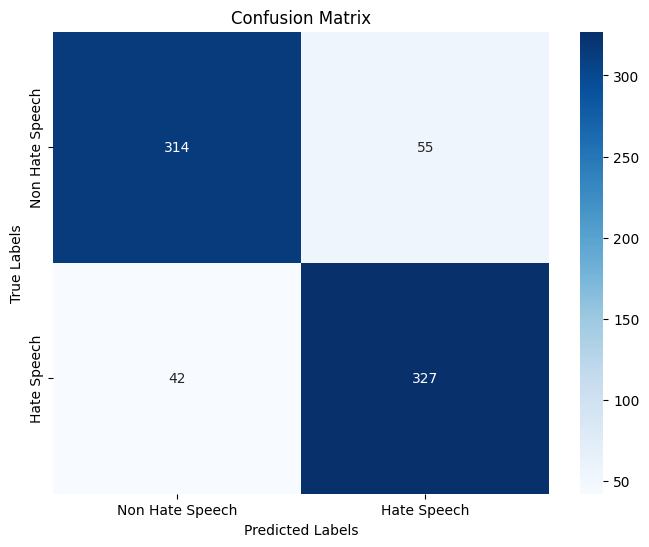

In [48]:
# Recharger le modèle et le tokenizer
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

# Créer un pipeline pour la classification
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Faire des prédictions sur l'ensemble de test
tweets_test = data_test['tweet'].tolist()
labels_test = data_test['label'].tolist()

# Prédire les labels
predictions = classifier(tweets_test)

# Extraire les labels prédits et les probabilités
predicted_labels = [pred['label'] for pred in predictions]
predicted_labels = [1 if label == 'LABEL_1' else 0 for label in predicted_labels]

# Afficher les métriques de classification
print("Classification Report:")
print(classification_report(labels_test, predicted_labels, target_names=['Non Hate Speech', 'Hate Speech']))

# Générer la matrice de confusion
conf_matrix = confusion_matrix(labels_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non Hate Speech', 'Hate Speech'],
            yticklabels=['Non Hate Speech', 'Hate Speech'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# 5. Local Web-Based User Interface